# 基于 MindSpore Quantum 实现量子 Q-JPEG 算法

## 1 课题背景：

图像压缩技术可以在保证可视化质量的同时降低处理、储存和传输图像的资源消耗。不仅在经典场景中，在量子机器学习场景，如量子卷积神经网络，也涉及图像处理任务。故而也需要图像压缩技术，以增强图像处理能力。

## 2 项目任务及实现方案：

本项目的核心任务是实现一种新型的量子图像压缩处理算法 — Q-JPEG (arXiv:2306.09323)。类似于经典的 JPEG 图像压缩技术，Q-JPEG 可以有效过滤掉图像中的高频分量，实现对图像的压缩。但由于压缩过程基于量子傅里叶变换，相比经典 JPEG 算法，Q-JPEG 具有指数级的加速效果。基于 Q-JPEG，可实现对经典及量子图像的高效压缩，并可进一步应用于图像识别等计算机视觉任务。

本项目基于 MindSpore Quantum 量子计算框架实现了该 Q-JPEG 算法，探索不同类型图像、及不同压缩比下的图像处理效果。

### Q-JPEG 算法

![circ](./images/circ.png)
图 1：QJPEG 算法流程示意图

Q-JPEG 算法的整体流程如图 1 所示。具体的，操作流程为：

1. 使用振幅编码，将经典图像编码为量子态；
2. 对量子态施加量子傅里叶变换，将图像从空域转换到频域；
3. 丢弃部分高位量子比特，保留图像的低频部分并对图像进行压缩；
4. 对剩余量子比特施加傅里叶逆变换；
5. 丢弃部分携带冗余信息的量子比特，进一步对图像进行压缩。

其中，Hadamard 变换层为可选操作。

### 算法实现及效果

下面基于 MindSpore Quantum 实现该算法。我们考虑将一幅图 2  所示，原始尺寸为 64*64 的 png 格式的灰度图进行压缩，并比较不同压缩比下的效果。

<img src="./images/ms_64_bin.png" alt="ms_64_bin" style="zoom:400%;" />

图 2：待处理的灰度图示例

#### 1. 图片加载

png 图片共有四个通道，我们只选用其中第一个通道进行处理。

In [ ]:
from PIL import Image
from mindquantum.simulator import Simulator
from mindquantum.core.circuit import Circuit, dagger, NoiseChannelAdder
from mindquantum.algorithm import qft
from mindquantum.utils import normalize
from mindquantum.core.gates import AmplitudeDampingChannel
import numpy as np
import matplotlib.pyplot as plt

ms_64_bin_4 = Image.open('./images/ms_64_bin.png')  # 读取PNG图片
ms_64_bin_array = np.array(ms_64_bin_4)[:, :, 0]  # 只选用第一通道的数据，并转换为numpy数组

#### 2. 定义操作比特

如图 1 所示，我们需要预先定义好处理前后所用量子比特，以及抛弃哪些比特。

In [2]:
n_qubits = 12  # 原图所用比特数
m_qubits = 10  # 现图所用比特数
half_diff = (n_qubits - m_qubits) // 2  # 每次抛弃掉的比特数 1
former_qubits = list(range(0, n_qubits // 2))  # 前半部分的比特 [0,1,2,3,4,5]
latter_qubits = list(range(n_qubits // 2, n_qubits))  # 后半部分的比特 [6,7,8,9,10,11]
mid_qubits = former_qubits[len(former_qubits) - half_diff :]  # 前半部分中要抛弃的比特 [5]
last_qubits = latter_qubits[len(latter_qubits) - half_diff :]  # 后半部分中要抛弃的比特 [11]

#### 3. 振幅编码

通过使用振幅编码技术，该图片可用一个 12  量子比特的系统进行编码。振幅编码过程可使用振幅编码线路制备，不过由于该过程不是本任务的核心环节，所以我们也可以直接使用归一化函数来产生，并将该量子态赋值给模拟器。

In [3]:
data = ms_64_bin_array.reshape(
    (
        int(
            2**n_qubits,
        )
    )
)  # 将图片数据重整化为矢量
state = normalize(data)  # 使用归一化函数直接将矢量转化为量子态
sim = Simulator('mqmatrix', n_qubits)  # 使用 mqmatrix 模拟器，因为后续需要进行求偏迹运算
sim.set_qs(state)  # 将产生的量子态赋值给模拟器

## 也可以使用振幅编码线路来制备该量子态
# encoder, parameterResolver = amplitude_encoder(data, n_qubits)
# sim.apply_circuit(encoder, parameterResolver)

#### 4. 执行 QJPEG 算法

In [4]:
circ = Circuit()
circ += qft(range(n_qubits))  # 傅里叶变换
circ += dagger(qft(range(n_qubits - half_diff)))  # 傅里叶逆变换

sim.apply_circuit(circ)
rho = sim.get_partial_trace(mid_qubits + last_qubits)  # 对抛弃的比特求偏迹
sub_pros = rho.diagonal().real  # 剩余密度矩阵的对角线元素即为不同结果出现的概率

#### 5. 结果可视化

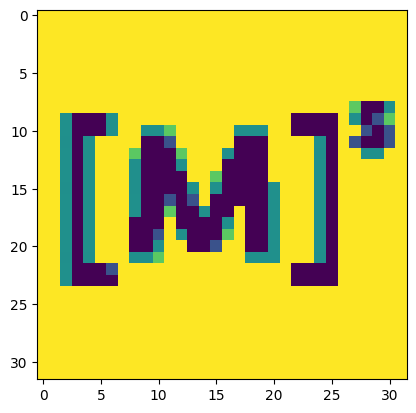

In [5]:
new_figure = sub_pros.reshape((2 ** (m_qubits // 2), -1))  # 转换为 32 * 32 的数组
plt.imshow(new_figure)

同样，如果我们设置 `m_qubits = 8` (更大压缩比)，可获得的图像如下图所示。该图的尺寸为 16* 16 可见更大压缩比下，失真更明显。

<img src="./images/ms_16.png" alt="ms_16" style="zoom:20%;" />

#### 6. 噪声分析

由于当前 NISQ 时期，量子系统不可避免地受到噪声影响，会产生不完美的输出结果。接下来我们讨论不同噪声强度下，QJPEG 算法的实现效果。需要指出的是，此处我们只关注 QJPEG 算法内部对噪声的鲁棒性，而不讨论量子态制备的问题。

作为展示，我们为每个量子门后后面都添加一个不同强度的振幅衰减信道，该操作可通过如下方式对量子线路进行修饰来完成。

In [6]:
strength = 0.001
channel = AmplitudeDampingChannel(strength)
adder = NoiseChannelAdder(channel, with_ctrl=True, add_after=True)
circ = adder(circ)

以 `m_qubits=10` 为例，下面四图分别展示了噪声强度为 0、0.0001、0.001、0.01 下 QJPEG 对图像的处理效果。从该结果中可以看出，该算法具有一定的鲁棒性，在噪声强度小于 0.001 以下，都表现出了较好的处理结果。

![noise](./images/noise.png)

### 算法封装

为便于后续用户使用，我们将该 QJPEG 算法封装为函数 qjpeg。

In [7]:
from mindquantum.simulator import Simulator
from mindquantum.core.circuit import Circuit, dagger
from mindquantum.algorithm import qft
from mindquantum.utils import normalize
import numpy as np
import matplotlib.pylab as plt
from PIL import Image
from typing import Union


def qjpeg(figure: Union[str, np.ndarray], n_qubits: int, m_qubits: int) -> np.ndarray:
    """对输入的 *.png 图片利用 QJPEG 算法进行压缩。"""
    if not isinstance(figure, np.ndarray):
        if figure[-4:] != ".png":
            raise ValueError("This function supports only *.png or np.ndarry figure.")
        figure = np.array(Image.open(figure))[:, :, 0]
    origin_figure = figure.reshape(-1)

    if not isinstance(n_qubits, int) or not isinstance(m_qubits, int):
        raise ValueError("n_qubits and m_qubits should be positive int.")
    if n_qubits <= 0 or m_qubits <= 0:
        raise ValueError("n_qubits and m_qubits should be positive int.")
    if n_qubits <= m_qubits:
        raise ValueError("m_qubits should little than n_qubits.")
    if np.log2(origin_figure.shape[0]) != n_qubits:
        print(np.log2(origin_figure.shape[0]))
        raise ValueError("the pixel number of the input figure should equal to 2**n_qubits.")
    if (n_qubits - m_qubits) % 2 != 0:
        raise ValueError("the different between n_qubits and m_qubits should be even.")

    half_diff = (n_qubits - m_qubits) // 2  # 每次抛弃掉的比特数
    former_qubits = list(range(0, n_qubits // 2))  # 前半部分的比特
    latter_qubits = list(range(n_qubits // 2, n_qubits))  # 后半部分的比特
    mid_qubits = former_qubits[len(former_qubits) - half_diff :]  # 前半部分中要抛弃的比特
    last_qubits = latter_qubits[len(latter_qubits) - half_diff :]  # 后半部分中要抛弃的比特

    state = normalize(origin_figure)
    sim = Simulator('mqmatrix', n_qubits)
    sim.set_qs(state)

    circ = Circuit()
    circ += qft(range(n_qubits))
    circ += dagger(qft(range(n_qubits - half_diff)))
    sim.apply_circuit(circ)
    rho = sim.get_partial_trace(mid_qubits + last_qubits)
    sub_pros = rho.diagonal().real
    new_figure = sub_pros.reshape((2 ** (m_qubits // 2), -1))
    return new_figure

### 案例测试

作为案例，我们使用两个网格图对该函数进行测试。在输出结果中，我们对处理前后的图像进行了可视化处理。结果显示，与预期结果一致，达到算法设计要求。

#### 测试案例一

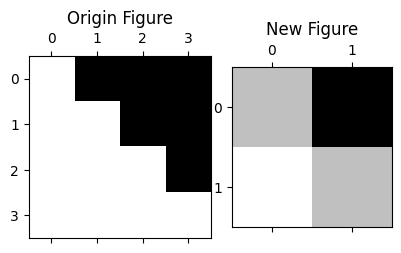

In [8]:
figure = np.array([[1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]])
n_qubits = 4  # 原图所用量子比特数
m_qubits = 2  # 现图所用量子比特数

new_figure = qjpeg(figure, n_qubits, m_qubits)
fig = plt.figure()
p_0 = fig.add_subplot(121)
s1 = p_0.matshow(figure, cmap=plt.cm.gray)
plt.title("Origin Figure")

p_1 = fig.add_subplot(132)
s1 = p_1.matshow(new_figure, cmap=plt.cm.gray)
plt.title("New Figure")
plt.subplots_adjust(left=0, bottom=0.5, right=1, wspace=0.5)
plt.show()

#### 测试案例二

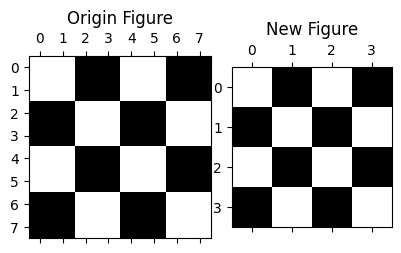

In [9]:
figure = np.zeros((8, 8))
figure[:2, :2] = 1
figure[4:6, :2] = 1
figure[:2, 4:6] = 1
figure[2:4, 2:4] = 1
figure[6:8, 2:4] = 1
figure[4:6, 4:6] = 1
figure[6:8, 6:8] = 1
figure[2:4, 6:8] = 1

n_qubits = 6  # 原图所用量子比特数
m_qubits = 4  # 现图所用量子比特数

new_figure = qjpeg(figure, n_qubits, m_qubits)
fig = plt.figure()
p_0 = fig.add_subplot(121)
s1 = p_0.matshow(figure, cmap=plt.cm.gray)
plt.title("Origin Figure")

p_1 = fig.add_subplot(132)
s1 = p_1.matshow(new_figure, cmap=plt.cm.gray)
plt.title("New Figure")
plt.subplots_adjust(left=0, bottom=0.5, right=1, wspace=0.5)
plt.show()

## 项目总结

综上所述，本项目基于 MindSpore Quantum 实现了 QJPEG 算法，并比较了不同压缩比下的图像处理效果，对算噪声鲁棒性进行了分析。此外，我们对该算法进行了函数封装，并利用具体的测试案例对该函数进行了测试，结果与预期一致。